In [124]:
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import librosa
from collections import defaultdict
from scipy.io import wavfile
import random
from collections import Counter
import pandas as pd

## EDA

In [60]:
input_folder = 'audio_data/train/audio/_background_noise_'
output_folder = 'audio_data/train/audio/silence'

os.makedirs(output_folder, exist_ok=True)

noise_files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]

sample_rate = 16000  # Hz
chunk_size = sample_rate * 1  # 1 second
n_samples = 400 # how many chunks per noise file

In [61]:
working_directory = os.getcwd()
np.random.seed(42)

for noise_file in noise_files:

    full_file_path = '{working_directory}/{input_folder}/{noise_file}'.format(working_directory = working_directory,
                                                                          input_folder=input_folder, 
                                                                          noise_file=noise_file)
    
    data, sr = librosa.load(full_file_path, sr=None)
    
    assert sr == sample_rate, f"Unexpected sample rate in {noise_file}"
    
    total_length = len(data)
    
    max_start = total_length - chunk_size
    start_indices = np.linspace(0, max_start, num=n_samples, dtype=int) # randomly choose starting points
    
    for i, start_idx in enumerate(start_indices):
        chunk = data[start_idx : start_idx + chunk_size]
        
        output_filename = f"{noise_file.replace('.wav', '')}_chunk{i}.wav"
        full_file_output_path = '{working_directory}/{output_folder}/{output_filename}'.format(working_directory = working_directory,
                                                                          output_folder=output_folder, 
                                                                          output_filename=output_filename)
        
        wavfile.write(full_file_output_path, sample_rate, chunk)



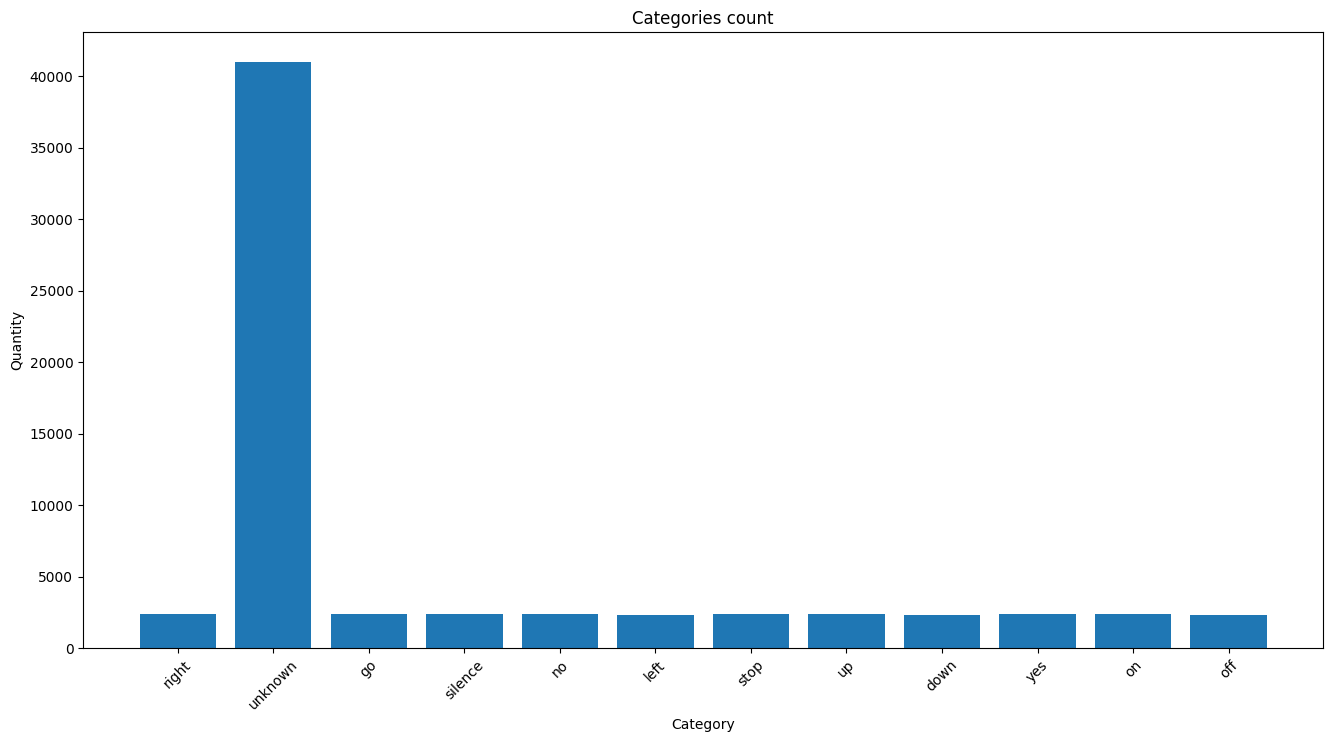

In [62]:
# getting categories, mapping other than 10 to predict to 'uknown'

train_path = 'audio_data/train/audio'

categories_to_predict = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence'] # rest are unknown

categories = [category for category in os.listdir(train_path) if category[0] != '.' and category != '_background_noise_']

categories_to_test = [(category if category in categories_to_predict else 'unknown') for category in categories ]

categories_count = [len(os.listdir('{train_path}/{category}'.format(train_path=train_path, category=category))) 
                     for category in categories]

# counting and grouping categories

group = defaultdict(int)

for cat, count in zip(categories_to_test, categories_count):
    group[cat] += count

grouped_categories = list(group.keys())
grouped_counts = list(group.values())

# ploting distribution

plt.figure(figsize=(16, 8))

plt.bar(grouped_categories, grouped_counts)

plt.title('Categories count')
plt.xlabel('Category')
plt.ylabel('Quantity')

plt.xticks(rotation=45)

plt.savefig('images_to_report/classes_distribution.png')
plt.show()

In [65]:
print('All train data:', sum(grouped_counts))
print('All test data:', len(os.listdir('audio_data/test/audio')))
print('Number of classes', len(grouped_categories))

# test data doesnt have labels, so train data is used for training, testing and validation according to testing_list.txt, validation_list.txt

All train data: 67121
All test data: 158538
Number of classes 12


In [66]:
# Checking example
example_no = 2
category = 'dog'
audio_filename = os.listdir('{working_directory}/{train_path}/{category}'.format(working_directory = os.getcwd(),
                                                                          train_path=train_path, 
                                                                          category=category))[example_no]

full_file_path = '{working_directory}/{train_path}/{category}/{filename}'.format(working_directory = os.getcwd(),
                                                                          train_path=train_path, 
                                                                          category=category,
                                                                          filename = audio_filename)


ipd.Audio(full_file_path)

In [36]:
# Sampling rate check <- number of samples taken per second from a continuous signal

y, sr = librosa.load(full_file_path, sr=None)  # sr=None to preserve original sampling rate
print("Sampling rate:", sr)
print('Number of elements in an array of a sound:', len(y)) # -> 1 second recordings

Sampling rate: 16000
Number of elements in an array of a sound: 16000


## UPDATING TEST AND VAL FILES

In [86]:
data_dir = 'audio_data/train/audio'
silence_dir = 'audio_data/train/audio/silence'
testing_list_path = 'audio_data/train/testing_list.txt'
validation_list_path = 'audio_data/train/validation_list.txt'
train_list_path = 'audio_data/train/training_list.txt'

def get_all_labels(base_dir):
    return sorted([
        d for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d != '_background_noise_'
    ])   

labels = get_all_labels(data_dir)

with open(testing_list_path, 'r') as f:
    testing_list = f.read().splitlines()
with open(validation_list_path, 'r') as f:
    validation_list = f.read().splitlines()

silence_files = sorted(os.listdir(silence_dir))

random.seed(123)
random.shuffle(silence_files)

testing_silence = [f'silence/{filename}' for filename in silence_files[0:200]]
validation_silence = [f'silence/{filename}' for filename in silence_files[200:400]]

testing_list_with_silence = testing_list + testing_silence
validation_list_with_silence = validation_list + validation_silence

with open('audio_data/train/testing_list_with_silence.txt', 'w') as f:
    f.write('\n'.join(testing_list_with_silence))

with open('audio_data/train/validation_list_with_silence.txt', 'w') as f:
    f.write('\n'.join(validation_list_with_silence))


# Auto-create training_list_with_silence.txt
if not os.path.exists(train_list_path):
    all_files = []
    for label in labels:
        folder = os.path.join(data_dir, label)
        for f in os.listdir(folder):
            rel_path = os.path.join(label, f)
            if rel_path not in set(validation_list_with_silence) and rel_path not in set(testing_list_with_silence):
                all_files.append(rel_path)
    with open('audio_data/train/training_list_with_silence.txt', 'w') as f:
        for path in all_files:
            f.write(f"{path}\n")

In [120]:
file_name = 'silence/doing_the_dishes_chunk167'
with open('audio_data/train/testing_list_with_silence.txt', 'r') as f:
    testing_list = f.read().splitlines()
    print(len(testing_list))
    print(len([f for f in testing_list if file_name in f]))

with open('audio_data/train/training_list_with_silence.txt', 'r') as f:
    validation_list = f.read().splitlines()
    print(len(validation_list))
    print(len([f for f in validation_list if file_name in f]))

with open('audio_data/train/validation_list_with_silence.txt', 'r') as f:
    training_list = f.read().splitlines()
    print(len(training_list))
    print(len([f for f in training_list if file_name in f]))


7035
1
53088
0
6998
0


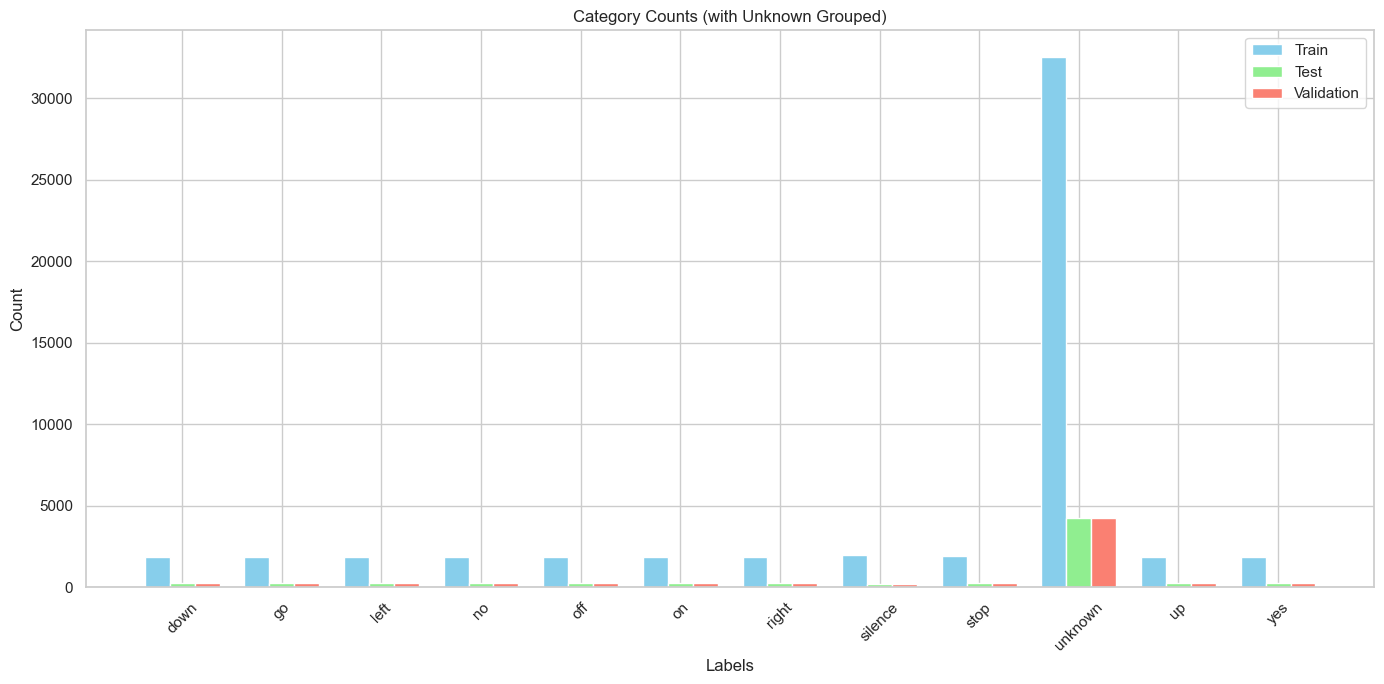

In [125]:
training_list = 'audio_data/train/training_list_with_silence.txt'
test_list = 'audio_data/train/testing_list_with_silence.txt'
validation_list = 'audio_data/train/validation_list_with_silence.txt'

def show_distribution_of_lists(training_list, test_list, validation_list):

    main_labels = {'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence'}

    # Function to count categories
    def get_label_counts(file_path):
        with open(file_path, 'r') as f:
            lines = f.read().splitlines()
        labels = [line.split('/')[0] for line in lines]
        
        # Group labels: if not in main_labels, call it 'unknown'
        grouped_labels = [label if label in main_labels else 'unknown' for label in labels]
        
        return Counter(grouped_labels)

    # Read and count
    train_counts = get_label_counts(training_list)
    test_counts = get_label_counts(test_list)
    val_counts = get_label_counts(validation_list)

    # Make sure 'unknown' exists even if absent
    all_labels = sorted(main_labels.union({'unknown'}))

    data = {
        'Label': all_labels,
        'Train': [train_counts.get(label, 0) for label in all_labels],
        'Test': [test_counts.get(label, 0) for label in all_labels],
        'Val': [val_counts.get(label, 0) for label in all_labels],
    }

    df = pd.DataFrame(data)

    # Plot prettier version
    import seaborn as sns
    sns.set(style="whitegrid")

    fig, ax = plt.subplots(figsize=(14, 7))

    bar_width = 0.25
    x = range(len(df))

    ax.bar([i - bar_width for i in x], df['Train'], width=bar_width, label='Train', color='skyblue')
    ax.bar(x, df['Test'], width=bar_width, label='Test', color='lightgreen')
    ax.bar([i + bar_width for i in x], df['Val'], width=bar_width, label='Validation', color='salmon')

    ax.set_xlabel('Labels')
    ax.set_ylabel('Count')
    ax.set_title('Category Counts (with Unknown Grouped)')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Label'], rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

show_distribution_of_lists(training_list, test_list, validation_list)

In [127]:
random.seed(123)

list_name = 'audio_data/train/training_list_with_silence.txt'

training_list = 'audio_data/train/training_list_with_silence.txt'
test_list = 'audio_data/train/testing_list_with_silence.txt'
validation_list = 'audio_data/train/validation_list_with_silence.txt'

def balance_list(list_name):

    classes_to_predict = {'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence'}

    with open(list_name, 'r') as f:
        lines = f.read().splitlines()

    main_class_samples = []
    unknown_samples = []

    for line in lines:
        category = line.split('/')[0]
        if category in classes_to_predict:
            main_class_samples.append(line)
        else:
            unknown_samples.append(line)

    selected_unknown_samples = random.sample(unknown_samples, int(len(unknown_samples)/18))

    final_lines = main_class_samples + selected_unknown_samples

    with open(f'{list_name.replace('.txt', '')}_balanced.txt', 'w') as f:
        for line in final_lines:
            f.write(line + '\n')

balance_list(training_list)
balance_list(test_list)
balance_list(validation_list)



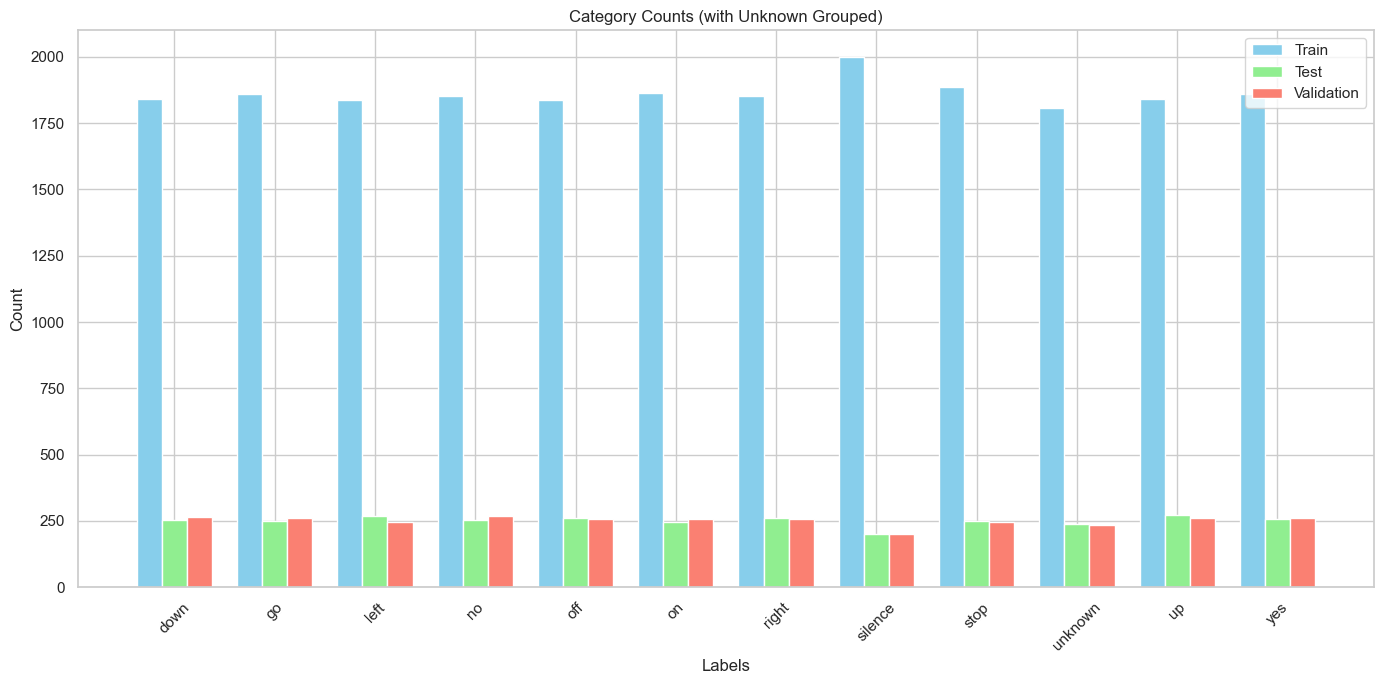

In [128]:
training_list = 'audio_data/train/training_list_with_silence_balanced.txt'
test_list = 'audio_data/train/testing_list_with_silence_balanced.txt'
validation_list = 'audio_data/train/validation_list_with_silence_balanced.txt'

def show_distribution_of_lists(training_list, test_list, validation_list):

    main_labels = {'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence'}

    # Function to count categories
    def get_label_counts(file_path):
        with open(file_path, 'r') as f:
            lines = f.read().splitlines()
        labels = [line.split('/')[0] for line in lines]
        
        # Group labels: if not in main_labels, call it 'unknown'
        grouped_labels = [label if label in main_labels else 'unknown' for label in labels]
        
        return Counter(grouped_labels)

    # Read and count
    train_counts = get_label_counts(training_list)
    test_counts = get_label_counts(test_list)
    val_counts = get_label_counts(validation_list)

    # Make sure 'unknown' exists even if absent
    all_labels = sorted(main_labels.union({'unknown'}))

    data = {
        'Label': all_labels,
        'Train': [train_counts.get(label, 0) for label in all_labels],
        'Test': [test_counts.get(label, 0) for label in all_labels],
        'Val': [val_counts.get(label, 0) for label in all_labels],
    }

    df = pd.DataFrame(data)

    # Plot prettier version
    import seaborn as sns
    sns.set(style="whitegrid")

    fig, ax = plt.subplots(figsize=(14, 7))

    bar_width = 0.25
    x = range(len(df))

    ax.bar([i - bar_width for i in x], df['Train'], width=bar_width, label='Train', color='skyblue')
    ax.bar(x, df['Test'], width=bar_width, label='Test', color='lightgreen')
    ax.bar([i + bar_width for i in x], df['Val'], width=bar_width, label='Validation', color='salmon')

    ax.set_xlabel('Labels')
    ax.set_ylabel('Count')
    ax.set_title('Category Counts (with Unknown Grouped)')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Label'], rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

show_distribution_of_lists(training_list, test_list, validation_list)